In [2]:
import data
import seaborn as sns
import numpy as np
import pandas as pd
import patsy
%matplotlib inline

/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
import pystan
import stanity

In [41]:
sns.set(context='talk')

## load files for all cell types

In [5]:
# list types of cells
subsets = data.prep_filename_metadata()
subsets['SubSet'].unique()
all_types = list(subsets['SubSet'].unique())
print(all_types)

['CD4_Th2', 'CD8_Effector', 'B_CD5', 'B_Memory', 'CD4_Th1', 'CD4_Naive', 'B_Naive', 'CD4_Effector_Memory', 'CD8_Central_Memory', 'CD4_Central_Memory', 'CD4_Treg', 'CD8_Naive', 'CD4_Th17']


In [6]:
df = data.load_by_cell_type(all_types, metadata=subsets)

In [7]:
df = data.prep_annotated_data(df)

In [8]:
assert all(pd.notnull(df['log1p_tpm_rescaled']))

## prep gene ids

For model-estimation, we first need to map each gene_name to a numeric ID. 


In [9]:
df['gene_cat'] = df['gene_name'].astype('category')
df['gene_id'] = df['gene_cat'].cat.codes+1

In [10]:
df['B_cell'] = df['cell_type'].apply(lambda x: 1 if x == 'B' else 0)
df['T_cell'] = df['cell_type'].apply(lambda x: 1 if x != 'B' else 0)

In [11]:
df.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CXCR3,SubSet,cell_type,log1p_tpm_rescaled_type,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell
0,1,ERR431566,A1BG,56.743290,6.931783,2.070878,4.056007,None,None,None,...,,CD4_Th2,CD4,-5.599303,-3.517738,-5.478180,A1BG,1,0,1
1,1,ERR431566,A1CF,5.194920,0.111335,0.105562,1.823730,None,None,None,...,,CD4_Th2,CD4,-1.164584,-1.529020,-0.735391,A1CF,2,0,1
2,1,ERR431566,A2M,10.000009,3.877857,1.584706,2.397896,None,None,None,...,,CD4_Th2,CD4,1.338389,-0.920287,1.188265,A2M,3,0,1
3,1,ERR431566,A2ML1,9.387660,1.860813,1.051106,2.340619,None,None,None,...,,CD4_Th2,CD4,1.092135,1.947468,0.895292,A2ML1,4,0,1
4,1,ERR431566,A2MP1,31.000030,3.441394,1.490968,3.465737,None,None,None,...,,CD4_Th2,CD4,1.945796,4.135726,1.532385,A2MP1,5,0,1


## sample genes for first pass

In [12]:
sampled_genes = df.drop_duplicates(subset='gene_name').sample(n=100).loc[:,'gene_name']
sample_df = pd.merge(df, pd.DataFrame(sampled_genes), on='gene_name', how='inner')

In [13]:
sample_df.head()

,sample_id,filename,gene_name,est_counts,tpm,log1p_tpm,log1p_counts,CCR6,CCR7,CD127,...,CXCR3,SubSet,cell_type,log1p_tpm_rescaled_type,log1p_tpm_rescaled_subset,log1p_tpm_rescaled,gene_cat,gene_id,B_cell,T_cell
0,1,ERR431566,AC005480.1,0.0,0.0,0.0,0.0,None,None,None,...,,CD4_Th2,CD4,-0.77223,0.0,-0.985435,AC005480.1,308,0,1
1,2,ERR431579,AC005480.1,0.0,0.0,0.0,0.0,None,None,None,...,,CD4_Th2,CD4,-0.77223,0.0,-0.985435,AC005480.1,308,0,1
2,3,ERR431600,AC005480.1,0.0,0.0,0.0,0.0,None,None,None,...,,CD4_Th2,CD4,-0.77223,0.0,-0.985435,AC005480.1,308,0,1
3,4,ERR431615,AC005480.1,0.0,0.0,0.0,0.0,None,None,None,...,,CD4_Th2,CD4,-0.77223,0.0,-0.985435,AC005480.1,308,0,1
4,5,ERR431628,AC005480.1,0.0,0.0,0.0,0.0,None,None,None,...,,CD4_Th2,CD4,-0.77223,0.0,-0.985435,AC005480.1,308,0,1


In [14]:
def prep_sample_df(df, sample_n=None):
    if sample_n:
        sampled_genes = df.drop_duplicates(subset='gene_name').sample(n=sample_n).loc[:,'gene_name']
        sample_df = pd.merge(df, pd.DataFrame(sampled_genes), on='gene_name', how='inner')
    else:
        sample_df = df
    sample_df['new_gene_cat'] = sample_df['gene_name'].astype('category')
    sample_df['new_gene_id'] = sample_df['new_gene_cat'].cat.codes+1
    sample_df['new_sample_cat'] = sample_df['sample_id'].astype('category')
    sample_df['new_sample_id'] = sample_df['new_sample_cat'].cat.codes+1
    return sample_df

def prep_stan_data(sample_df):
    stan_data = {'N': len(sample_df.index),
             'G': len(sample_df.new_gene_id.unique()),
             'S': len(sample_df.new_sample_id.unique()),
             'C': 2,
             'gene': sample_df.new_gene_id.values,
             'sample': sample_df.new_sample_id.values,
             'x': patsy.dmatrix('0 + B_cell + T_cell', data=sample_df, return_type='dataframe'),
             'y': sample_df.est_counts.astype(int).values,
            }
    return stan_data

    

## fit model at level of cell-type

In [15]:
sample_df = prep_sample_df(df, sample_n=100)
stan_data = prep_stan_data(sample_df)

In [16]:
## rewrite stan code to try to use matrix representation
## (ultimately, seems likely we will want to use sparse matrices)
stan_code2 = '''
data {
    // dimensions
    int<lower=1> N;  // N obs
    int<lower=1> G;  // N genes
    int<lower=1> S;  // N samples
    int<lower=0> C;  // N classes (e.g. B-cell, T-cell, B_Naive, CD5, CD45RO, etc)
                     // note: classes should be mutually exclusive. Each row here should sum to 1
   
    // data
    int<lower=1, upper=G> gene[N];    // gene id for each obs
    int<lower=1, upper=S> sample[N];  // sample id for each obs
    vector<lower=0, upper=1>[C] x[N]; // map each obs to each class (0:'- or ?', 1:'+')
    int<lower=0> y[N];                // count/tpm for each obs
}
transformed data {
    int sample_y[S, G]; // array (size SxG) of ints
    vector[C] sample_x[S]; // array (size S) of vectors[C]
    for (n in 1:N) {
        sample_y[sample[n], gene[n]] = y[n];
        sample_x[sample[n]] = x[n,];
    }
}
parameters {
    matrix<lower=0>[G, C] theta;   // loading factors for each gene, for each cell type
    real log_gene_base[G];    // constant intercept expression level for each gene, irrespective of cell type
}
model {
    for (i in 1:G)
        theta[i] ~ normal(log_gene_base[i], 1);
    log_gene_base ~ normal(0, 1);
    for (s in 1:S) {
        vector[G] expected_rate;
        expected_rate = theta*sample_x[s];
        sample_y[s] ~ poisson(expected_rate);
    }
}
generated quantities {
    int y_rep[N];
    real log_lik[N];
    
    for (n in 1:N) {
        real expected_rate;
        expected_rate = theta[gene[n], ]*x[n];
        y_rep[n] = poisson_rng(expected_rate);
        log_lik[n] = poisson_lpmf(y[n] | expected_rate);
    }
}
'''

In [17]:
fit2 = data.cached_stan_fit(model_code=stan_code2, data=stan_data, iter=5000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0362613046cf5165bc95a72d38d84cf7 NOW.


NOT reusing model.
Ran in 345.669 sec.


/home/jacquelineburos/projects/immune-infiltrate-explorations/.env/lib/python3.5/site-packages/pyfscache/fscache.py:407: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


## summarize parameter `theta` for T & B cells

In [18]:
data.print_stan_summary(fit2, pars='theta')

                    mean   se_mean        sd         2.5%          50%        97.5%      Rhat
theta[0,0]      0.212210  0.001212  0.121157     0.043615     0.189129     0.500276  0.999788
theta[1,0]      0.907449  0.002479  0.247949     0.482422     0.883864     1.445294  0.999682
theta[2,0]      1.103789  0.002713  0.271327     0.631900     1.083588     1.697902  0.999828
theta[3,0]      1.243718  0.002877  0.287713     0.749645     1.221184     1.860205  0.999741
theta[4,0]      0.695173  0.002127  0.212711     0.337292     0.673307     1.167476  0.999781
theta[5,0]      0.141263  0.000978  0.097777     0.018121     0.119121     0.380079  0.999821
theta[6,0]      5.656357  0.005366  0.536621     4.650735     5.643643     6.736276  0.999657
theta[7,0]    823.208842  0.011469  1.146874   820.974634   823.202708   825.467796  0.999733
theta[8,0]      2.252930  0.003689  0.368857     1.579967     2.237358     3.033970  0.999754
theta[9,0]      3.731158  0.004624  0.462370     2.853656   

In [19]:
theta_ldf = data.prep_theta_summary(fit2, sample_df=sample_df)

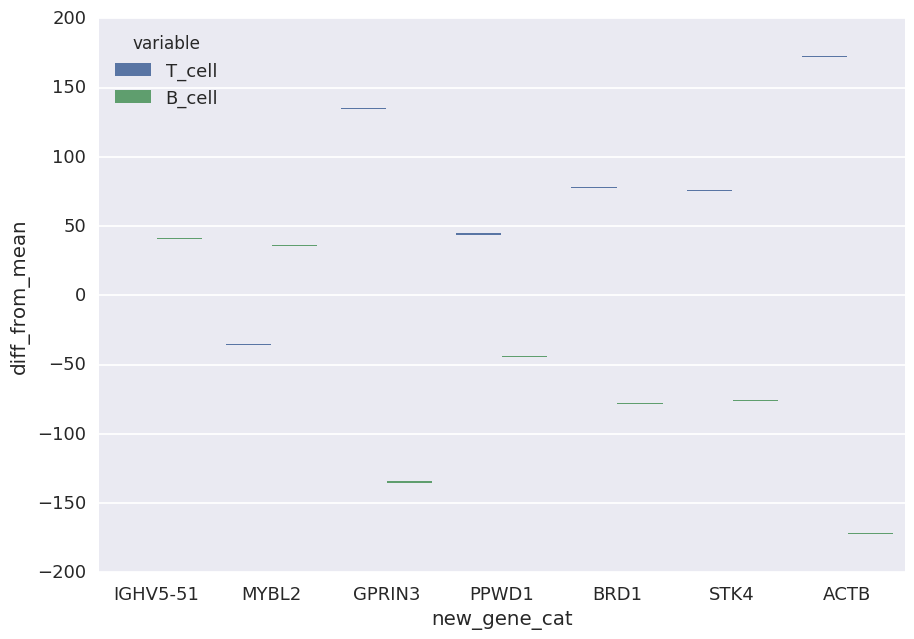

In [44]:
g = sns.boxplot(data=theta_ldf.query("abs(diff_from_mean)>30").sort_values('mean_value'),
            x='new_gene_cat',
            y='diff_from_mean',
            hue='variable', 
            fliersize=0, linewidth=0)

## plot distribution in ratio 

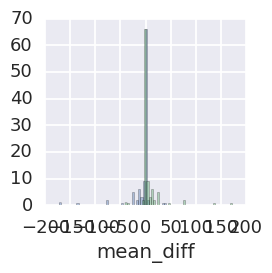

In [51]:
g = sns.FacetGrid(data=theta_ldf.drop_duplicates(subset=['new_gene_id','variable', 'mean_diff']),
                  hue='variable'
                 )
g.map(sns.distplot, 'mean_diff', kde=False)


## summarize y_rep for these samples

In [56]:
yrep_pdf = data.prep_yrep_summary(fit2, sample_df)

In [53]:
from matplotlib import pyplot as plt
sns.boxplot(data=yrep_df.query('gene_cat == "EBF1"'),
            x='cell_type',
            y='pp_est_counts',
            fliersize=0, linewidth=0.2)
sns.swarmplot(data=sample_df.loc[sample_df['gene_cat'] == "EBF1", :],
           x='cell_type',
           y='est_counts', color='black')

,iter,0,1,2,3,4,5,6,7,8,...,6290,6291,6292,6293,6294,6295,6296,6297,6298,6299
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,2.0,1.0,2.0,0.0,2.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,2.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,1.0
2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0
4,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0
